# Test validity step 2 : $P(s_c | ...) \propto (s_c - s_{c,WF})^t (C^{-1} + (E^t (B^t N^{-1} B)^{-1} E)^{-1}) (s_c - s_{c,WF})$

In [21]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
from jax import random, dtypes
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import numpyro.distributions as dist

import micmac as micmac

In [22]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# freq_maps is defined there

In [23]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,27.0,49.5,35.0,91.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
1,39.0,29.7,21.0,63.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
2,93.0,3.7,2.6,30.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
3,145.0,4.7,3.3,17.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
4,225.0,8.9,6.3,11.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
5,280.0,22.6,16.0,9.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT


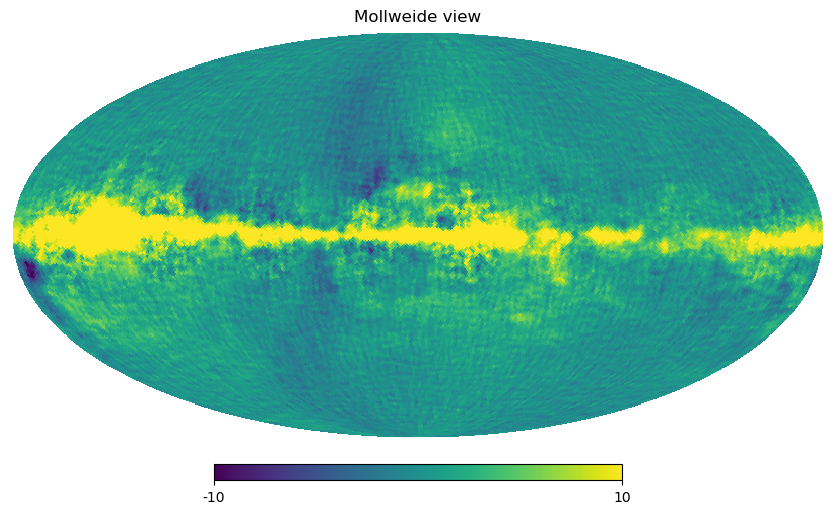

In [24]:
hp.mollview(freq_maps[2,0], min=-10, max=10) # Freq, nstokes, npix

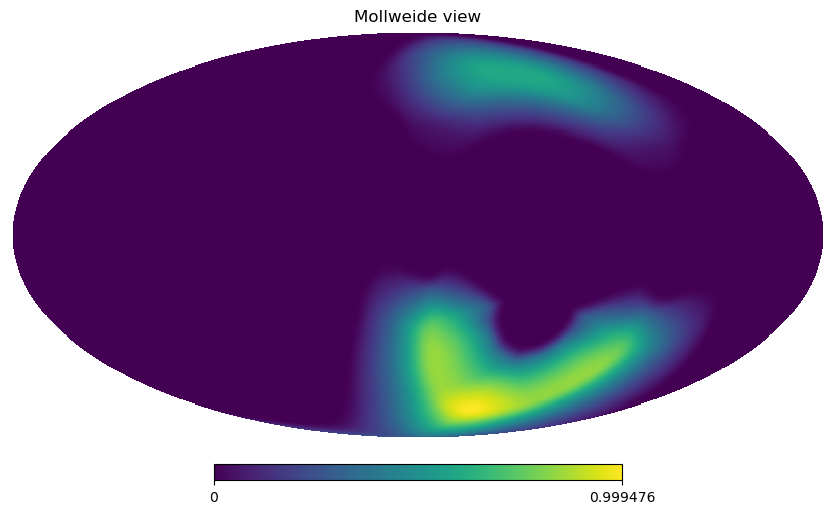

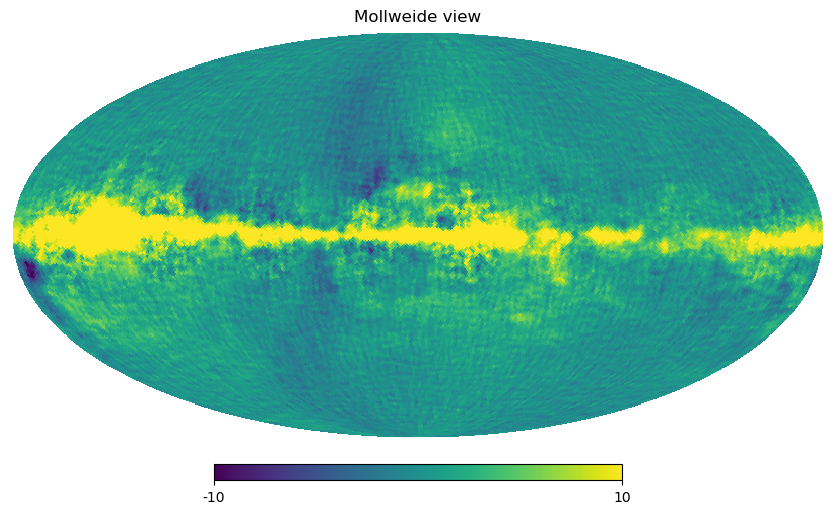

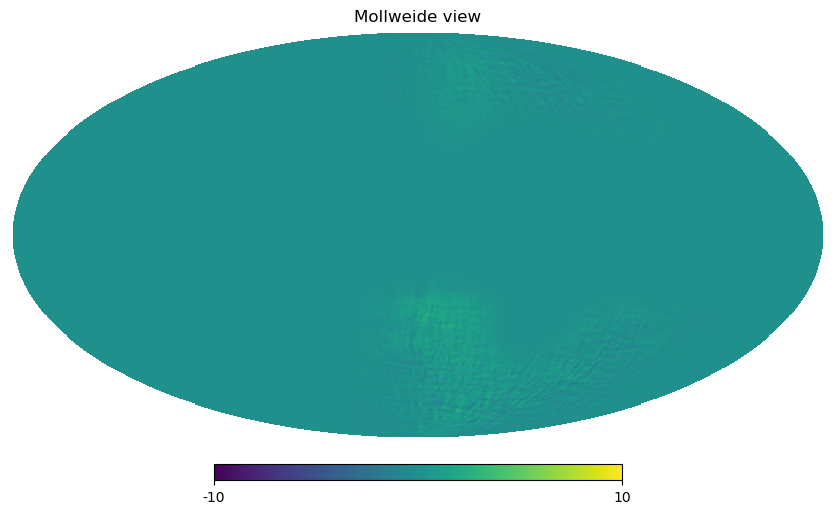

In [25]:
path_mask_test = "/Users/mag/Documents/PHD1Y/Masks/mask_SAT_apodized.fits"

mask_test = hp.read_map(path_mask_test)
hp.mollview(mask_test)
hp.mollview(freq_maps[2,0], min=-10, max=10) # Freq, nstokes, npixhp.mollview(freq_maps[0,0]) # Freq, nstokes, npix
hp.mollview(freq_maps[2,0]*hp.ud_grade(mask_test,nside_out=64), min=-10, max=10) # Freq, nstokes, npix

In [26]:
# working_directory_path = os.path.abspath('') + '/'
working_directory_path = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/validation_chain_v4/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'toml_params/'

path_toml_file = directory_toml_file + 'test_full_chain_v1a.toml'
path_toml_file = directory_toml_file + 'test_classical_chain_v1a.toml'
path_toml_file = directory_toml_file + 'test_full_chain_v1d.toml'
path_toml_file = directory_toml_file + 'corr_full_chain_v3a.toml'


In [27]:
MICMAC_sampler_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file)

In [28]:
reduction_noise = 1

In [29]:
freq_inverse_noise = micmac.get_noise_covar(instrument['depth_p']/reduction_noise, MICMAC_sampler_obj.nside)

In [30]:
instrument = get_instrument(instr_name)

instrument['depth_p'] /= reduction_noise
# get input freq maps
np.random.seed(noise_seed)
# freq_maps = get_observation(instrument, model, nside=NSIDE, noise=noise)[:, 1:, :]   # keep only Q and U
freq_maps_fgs = get_observation(instrument, fgs_model, nside=MICMAC_sampler_obj.nside, noise=noise)[:, 1:, :]   # keep only Q and U


In [31]:
indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:MICMAC_sampler_obj.nstokes]

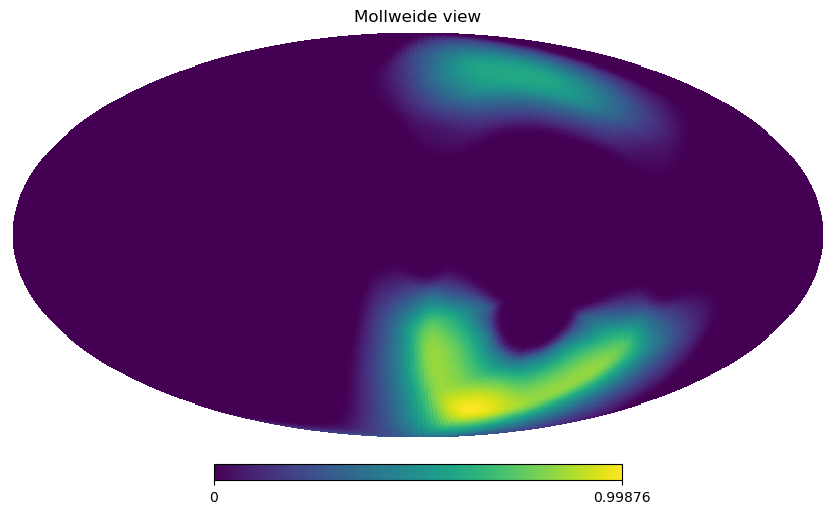

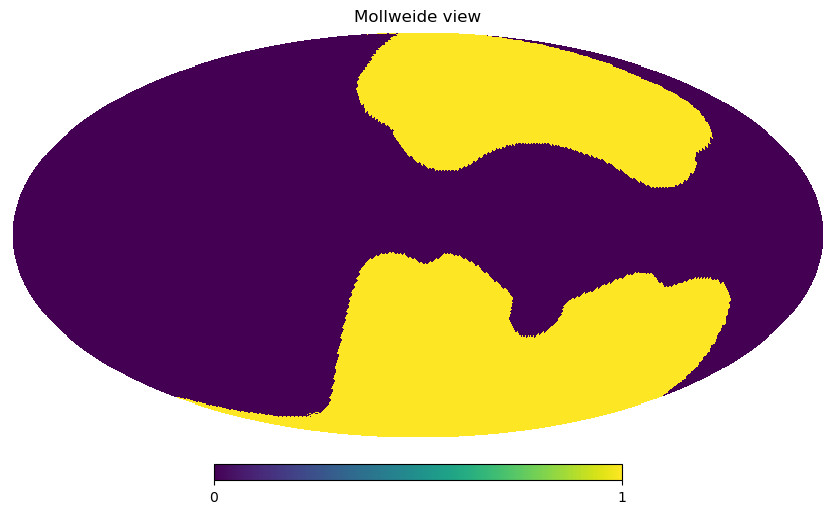

In [32]:
path_mask = "/Users/mag/Documents/PHD1Y/Masks/mask_SAT_apodized.fits"

apod_mask = hp.ud_grade(hp.read_map(path_mask_test),nside_out=MICMAC_sampler_obj.nside)
mask = np.copy(apod_mask)
mask[apod_mask>0] = 1
hp.mollview(apod_mask)
hp.mollview(mask)

In [33]:
MICMAC_sampler_obj.mask = mask

In [34]:
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), MICMAC_sampler_obj.number_components, pos_special_freqs=MICMAC_sampler_obj.pos_special_freqs)
init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], MICMAC_sampler_obj.number_components, init_params, pos_special_freqs=MICMAC_sampler_obj.pos_special_freqs)

mixing_matrix_sampled = mixing_matrix_obj.get_B()

BtinvNB_fullsky = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)#*mask
BtinvN_sqrt_fullsky = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)#*mask
BtinvN_fullsky = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)#*mask

nb_pix_mask = int(np.sum(mask))

BtinvNB = np.zeros((MICMAC_sampler_obj.number_components,MICMAC_sampler_obj.number_components,MICMAC_sampler_obj.npix))
BtinvNB[:,:,mask!=0] = np.repeat(BtinvNB_fullsky.ravel(order='C'), nb_pix_mask).reshape((MICMAC_sampler_obj.number_components, MICMAC_sampler_obj.number_components, nb_pix_mask), order='C')

BtinvN_sqrt = np.zeros((MICMAC_sampler_obj.number_components,MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.npix))
BtinvN_sqrt[:,:,mask!=0] = np.repeat(BtinvN_sqrt_fullsky.ravel(order='C'), nb_pix_mask).reshape((MICMAC_sampler_obj.number_components, MICMAC_sampler_obj.number_frequencies, nb_pix_mask), order='C')

BtinvN = np.zeros((MICMAC_sampler_obj.number_components,MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.npix))
BtinvN[:,:,mask!=0] = np.repeat(BtinvN_fullsky.ravel(order='C'), nb_pix_mask).reshape((MICMAC_sampler_obj.number_components, MICMAC_sampler_obj.number_frequencies, nb_pix_mask), order='C')


In [15]:
input_freq_maps, input_cmb_maps, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

input_freq_maps_masked = input_freq_maps*mask
# true_cmb_specra = get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true*theoretical_red_cov_r1_tensor)
# true_cmb_specra_extended = np.zeros((6,MICMAC_sampler_obj.lmax+1))
# true_cmb_specra_extended[indices_polar,MICMAC_sampler_obj.lmin:] = true_cmb_specra

# input_cmb_maps_alt = hp.synfast(true_cmb_specra_extended, nside=MICMAC_sampler_obj.nside, new=True, lmax=MICMAC_sampler_obj.lmax)[1:,...]

# input_cmb_maps = np.repeat(input_cmb_maps_alt.ravel(order='F'), MICMAC_sampler_obj.number_frequencies).reshape((MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix),order='F')

# input_cmb_maps = 

Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [16]:
s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, input_freq_maps_masked, jax_use=False)[0, :, :]

In [17]:
red_cov_matrix_sample = theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor

In [18]:
number_frequencies = MICMAC_sampler_obj.number_frequencies
number_components = MICMAC_sampler_obj.number_components
nstokes = MICMAC_sampler_obj.nstokes
lmin = MICMAC_sampler_obj.lmin
lmax = MICMAC_sampler_obj.lmax
nside = MICMAC_sampler_obj.nside
n_iter = MICMAC_sampler_obj.n_iter
npix = 12*nside**2

In [42]:
def get_fluctuating_term_maps_test(red_cov_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, mask_to_use=None, map_random_realization_xi=jnp.empty(0), map_random_realization_chi=jnp.empty(0), initial_guess=jnp.empty(0)):

    # assert red_cov_matrix.shape[0] == param_dict['lmax'] + 1 - lmin
    chx.assert_axis_dimension(red_cov_matrix, 0, lmax + 1 - lmin)

    red_inverse_cov_matrix = jnp.linalg.pinv(red_cov_matrix)
    
    mask_to_use = jnp.ones((npix)) if mask_to_use is None else mask_to_use

    jax_key_PNRG, jax_key_PNRG_xi = random.split(jax_key_PNRG)
    # Creation of the random maps
    if jnp.size(map_random_realization_xi) == 0:
        print("Recalculating xi !")
        # map_random_realization_xi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["nstokes"],12*param_dict["nside"]**2))
        map_random_realization_xi = jax.random.normal(jax_key_PNRG_xi, shape=(nstokes,npix))/jhp.nside2resol(nside)#*mask_to_use
    
    jax_key_PNRG, *jax_key_PNRG_chi = random.split(jax_key_PNRG,number_frequencies+1)
    if jnp.size(map_random_realization_chi) == 0:
        print("Recalculating chi !")
        # map_random_realization_chi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["number_frequencies"],param_dict["nstokes"],12*param_dict["nside"]**2))
        # map_random_realization_chi = jax.random.normal(jax_key_PNRG, shape=(number_frequencies,nstokes,npix))#/jhp.nside2resol(nside)
        def fmap(random_key):
            # random_map = jax.random.normal(jax_key_PNRG_chi[index_freq], shape=(nstokes,npix))#/jhp.nside2resol(nside)
            random_map = jax.random.normal(random_key, shape=(nstokes,npix))#/jhp.nside2resol(nside)
            return MICMAC_sampler_obj.get_band_limited_maps(random_map)
        map_random_realization_chi = jax.vmap(fmap)(jnp.array(jax_key_PNRG_chi))

    # Computation of the right side member of the CG
    red_inv_cov_sqrt = get_sqrt_reduced_matrix_from_matrix_jax(red_inverse_cov_matrix)

    # First right member : C^{-1/2} \xi
    right_member_1 = maps_x_red_covariance_cell_JAX(map_random_realization_xi, red_inv_cov_sqrt, nside=nside, lmin=lmin, n_iter=n_iter)

    N_c_inv = jnp.copy(BtinvNB[0,0])
    N_c_inv = N_c_inv.at[...,mask!=0].set(1/BtinvNB[0,0,mask!=0]/jhp.nside2resol(nside)**2)
    N_c_inv_repeat = np.repeat(N_c_inv.ravel(order='C'), MICMAC_sampler_obj.nstokes).reshape((MICMAC_sampler_obj.nstokes,npix), order='F').ravel()

    ## Left hand side term : (E^t (B^t N^{-1} B)^{-1} B^t N^{-1/2} \chi
    # right_member_2 = jnp.einsum('kc,cf,fsp->ksp', BtinvNB, BtinvN_sqrt, map_random_realization_chi)[0]/BtinvNB[0,0] # Selecting CMB component of the random variable
    # right_member_2 = jnp.einsum('kcp,cfp,fsp->ksp', BtinvNB, BtinvN_sqrt, map_random_realization_chi)[0]/BtinvNB[0,0]/jhp.nside2resol(nside)**2 # Selecting CMB component of the random variable
    right_member_2 = jnp.einsum('kcp,cfp,fsp->ksp', BtinvNB, BtinvN_sqrt, map_random_realization_chi)[0]*N_c_inv # Selecting CMB component of the random variable

    right_member = (right_member_1 + right_member_2).ravel()

    # Computation of the left side member of the CG
    
    # First left member : C^{-1} 
    first_term_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((nstokes,npix)), red_inverse_cov_matrix, nside=nside, lmin=lmin, n_iter=n_iter)

    ## Second left member : (E^t (B^t N^{-1} B) E)
    def second_term_left(x, number_component=number_components):
        return x*N_c_inv_repeat
        # x_new = x.reshape((nstokes, npix))*N_c_inv
        # return jnp.ravel(x_new)#/jhp.nside2resol(nside)**2
        # return x/BtinvNB[0,0]/jhp.nside2resol(nside)**2

    func_left_term = lambda x : first_term_left(x).ravel() + second_term_left(x).ravel()
    # Initial guess for the CG
    if jnp.size(initial_guess) == 0:
        initial_guess = jnp.zeros_like(map_random_realization_xi)

    # Actual start of the CG
    # fluctuating_map, number_iterations, exit_code = generalized_cg_from_func(initial_guess.ravel(), func_left_term, right_member, limit_iter_cg=limit_iter_cg, tolerance=tolerance)
    fluctuating_map, number_iterations = jsp.sparse.linalg.cg(func_left_term, right_member.ravel(), x0=initial_guess.ravel(), tol=MICMAC_sampler_obj.tolerance_CG, atol=MICMAC_sampler_obj.tolerance_CG, maxiter=MICMAC_sampler_obj.limit_iter_cg)
    print("CG-Python-0 Fluct finished in ", number_iterations, "iterations !!")

    # if exit_code != 0:
    #     print("CG didn't converge with fluctuating term ! Exitcode :", exit_code, flush=True)
    return fluctuating_map.reshape((nstokes, npix))

In [43]:
N_c_inv = jnp.copy(BtinvNB[0,0])
N_c_inv = N_c_inv.at[...,mask!=0].set(1/BtinvNB[0,0,mask!=0]/jhp.nside2resol(nside)**2)

N_c_inv_repeat = np.repeat(N_c_inv.ravel(order='C'), MICMAC_sampler_obj.nstokes).reshape((MICMAC_sampler_obj.nstokes,npix), order='F').ravel()

In [53]:
N_c_inv_repeat[:npix][N_c_inv_repeat[:npix]!=N_c_inv]

Array([], dtype=float64)

In [45]:
PRNGKey = random.PRNGKey(0)
map_random_realization_xi = jnp.empty(0)
map_random_realization_chi = jnp.empty(0)
# fluctuation_maps = MICMAC_sampler_obj.get_fluctuating_term_maps(red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey+2, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=jnp.empty(0))
fluctuation_maps = get_fluctuating_term_maps_test(red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey+2, mask_to_use=mask, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=jnp.empty(0))
print("Finished fluct !")

wiener_filter_term = MICMAC_sampler_obj.solve_generalized_wiener_filter_term(s_cML, red_cov_matrix_sample, BtinvNB, initial_guess=jnp.empty(0))


s_c_sample = wiener_filter_term + fluctuation_maps

Recalculating xi !
Recalculating chi !
CG-Python-0 Fluct finished in  None iterations !!
Finished fluct !
CG-Python-0 WF finished in  None iterations !!


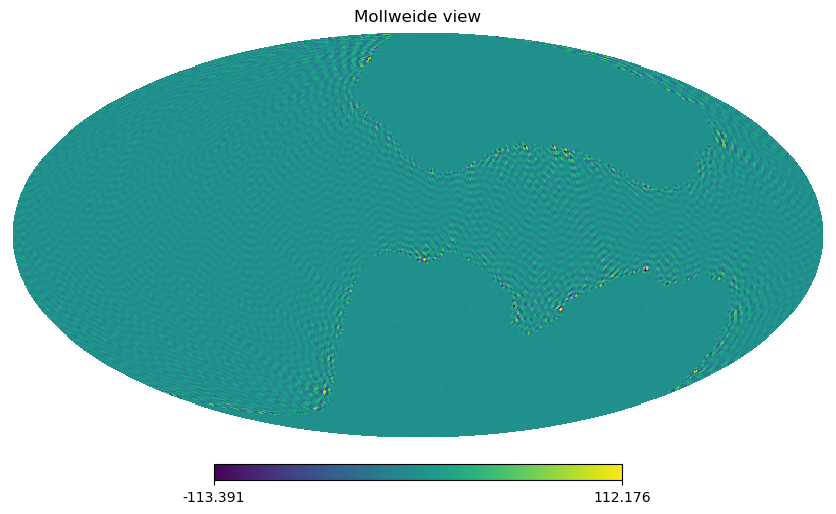

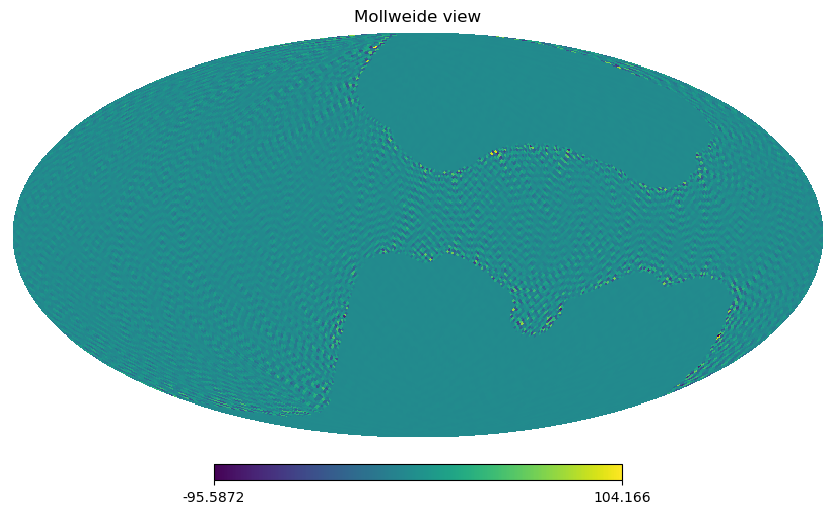

In [46]:
hp.mollview(s_c_sample[0])
hp.mollview(s_c_sample[1])

In [47]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

In [48]:
_cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled, lmax)[0,0,lmin:]
red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))
cl_noise_harm = micmac.get_c_ells_from_red_covariance_matrix(red_cl_noise_harm)

In [51]:
fsky = mask.sum()/mask.size
fsky = 1#mask.sum()/mask.size

/var/folders/f8/p6tqlgxj2qn5x_tyjrvc1vnh0000gn/T/ipykernel_36344/1727640150.py:12: RuntimeWarning: invalid value encountered in divide
  analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0]/hp.nside2resol(MICMAC_sampler_obj.nside)**2,
/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


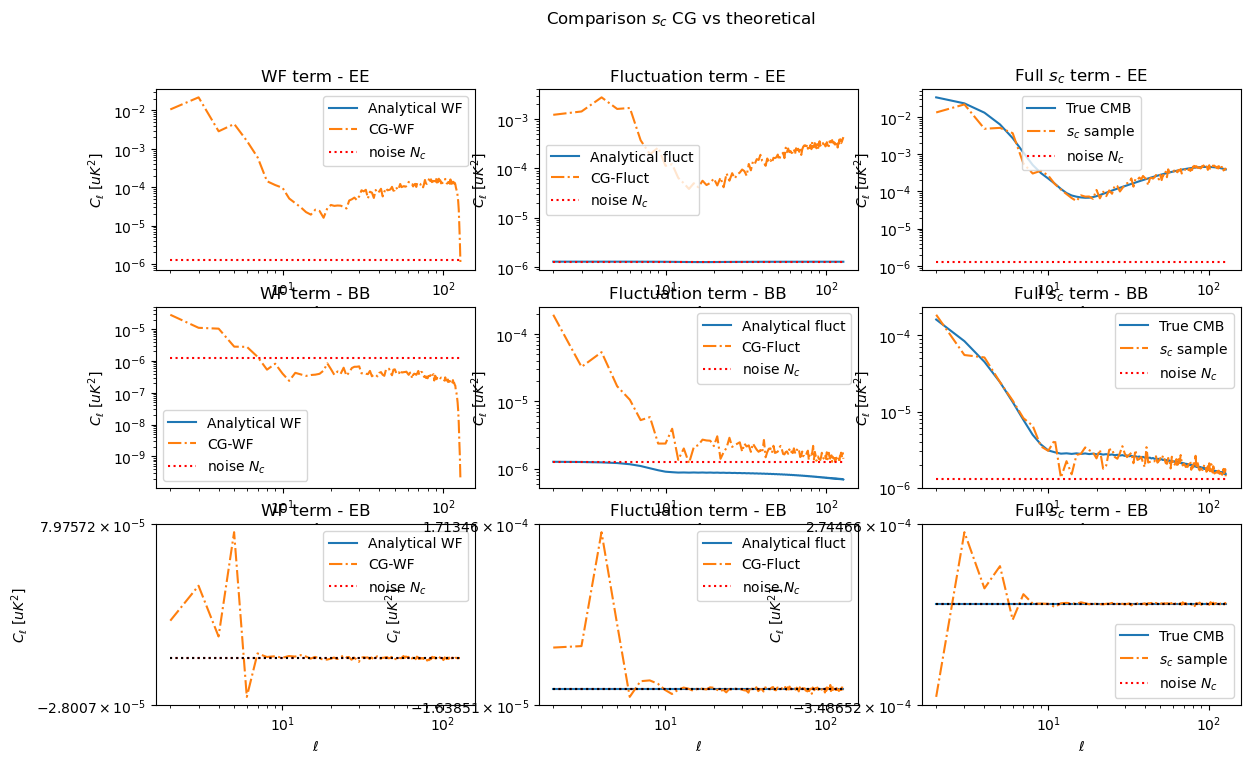

In [52]:
list_correl = ['EE', 'BB', 'EB']

c_ell_true_CMB = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor)

covariance_noise = np.zeros_like(c_ell_true_CMB)

# analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix_sample) + np.eye(nstokes)/BtinvNB[0,0])
# # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
# analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0], analytical_WF_harm, lmin=lmin, n_iter=n_iter)
analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix_sample) + np.linalg.pinv(red_cl_noise_harm))
# analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0]/hp.nside2resol(MICMAC_sampler_obj.nside)**2,
                                                                        analytical_WF_harm, lmin=lmin, n_iter=n_iter)


analytical_WF_map_ext = np.vstack([np.zeros_like(analytical_WF_map[0]),analytical_WF_map])
analytical_WF_cells = hp.anafast(analytical_WF_map_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]
analytical_fluct_c_ell = micmac.get_c_ells_from_red_covariance_matrix(analytical_WF_harm.copy())#[indices_polar,lmin:]

s_c_WF_maps_extended = np.vstack([np.zeros_like(wiener_filter_term[0,...]), wiener_filter_term])
c_ells_s_c_WF = hp.anafast(s_c_WF_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_fluct_maps_extended = np.vstack([np.zeros_like(fluctuation_maps[0,...]), fluctuation_maps])
c_ells_s_c_fluct = hp.anafast(s_c_fluct_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_recovered_ext = np.vstack([np.zeros_like(s_c_sample[0]),s_c_sample])
c_ells_s_c = hp.anafast(s_c_recovered_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

plt.figure(figsize=(14,8))
plt.suptitle(r"Comparison $s_c$ CG vs theoretical")

for j in range(number_correl_to_plot):
    plt.subplot(331+3*j)
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, analytical_WF_cells[j,:], label='Analytical WF')
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, c_ells_s_c_WF[j,:]/fsky, '-.', label='CG-WF')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')
    if j <= nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('WF term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()

    plt.subplot(332+3*j)
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, analytical_fluct_c_ell[j,:], label='Analytical fluct')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c_fluct[j,:]/fsky, '-.', label='CG-Fluct')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

    if j <= nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('Fluctuation term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()
    
    plt.subplot(333+3*j)
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, c_ell_true_CMB[j,:], label='True CMB')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c[j,:]/fsky, '-.', label='$s_c$ sample')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

    if j <= nstokes-1:
        plt.loglog()
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('Full $s_c$ term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    
    plt.xlabel(r"$\ell$")
    plt.legend()


plt.show()